##1. Loading Models: MAE and DINOv2

In [ ]:
# 1) Make sure you have a recent timm + huggingface_hub
!pip install timm>=0.6.12 huggingface_hub

# 2) Imports
import torch
from timm import create_model

# 3) MAE (as you already did) using the HF checkpoint:
mae = create_model('vit_huge_patch14_224.mae', pretrained=True)
mae.eval()

# 4) DINOv2 via timm + HF
#    – model name is exactly the HF repo: "vit_large_patch14_dinov2.lvd142m"
dino = create_model(
    'vit_large_patch14_dinov2.lvd142m',
    pretrained=True,
    img_size=(224,224)    # force it to re‐init patch_embed for 224×224
)

dino.eval()

# 5) Quick smoke test
x = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    f_mae  = mae(x)    # [1, 1024] for huge‐14
    f_dino = dino(x)   # [1, 1024] for large‐14
print(f_mae.shape, f_dino.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

torch.Size([1, 1280]) torch.Size([1, 1024])


##2. Define your Data Pipeline

In [ ]:
# 1) Extract the tarball into /content/ssl4eo
import tarfile, os

ARCHIVE = "/content/ssl4eo/ssl4eo-s12_100patches.tar.gz"
TARGET  = "/content/ssl4eo"
assert os.path.exists(ARCHIVE), f"{ARCHIVE} not found!"

with tarfile.open(ARCHIVE, "r:gz") as tar:
    tar.extractall(path=TARGET)

# 2) Verify the folder structure
print(os.listdir(TARGET))

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# shared normalize (ImageNet stats)
normalize = transforms.Normalize(mean=(0.485,0.456,0.406),
                                 std=(0.229,0.224,0.225))

# transforms for MAE (already 224×224)
mae_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])

# transforms for DINO (we forced it to 224×224 too)
dino_transform = mae_transform

# load as an ImageFolder
dataset = datasets.ImageFolder(
    root='/content/ssl4eo/rgb',
    transform=mae_transform  # or dino_transform when extracting for DINO
)

loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


##3. Extract & Save Features

In [ ]:
import numpy as np
features_mae, features_dino, labels = [], [], []

for imgs, lbls in loader:
    with torch.no_grad():
        f1 = mae(imgs)    # [B,1280]
        f2 = dino(imgs)   # [B,1024]
    features_mae.append(f1.cpu().numpy())
    features_dino.append(f2.cpu().numpy())
    labels.append(lbls.numpy())

features_mae = np.concatenate(features_mae, axis=0)
features_dino = np.concatenate(features_dino, axis=0)
labels       = np.concatenate(labels, axis=0)

np.save('feat_mae.npy', features_mae)
np.save('feat_dino.npy', features_dino)
np.save('labels.npy', labels)


##4. Run a Downstream Task

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features_mae, labels, test_size=0.2, random_state=0
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("MAE Linear‐probe accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


MAE Linear‐probe accuracy: 0.3875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Low support per class
Most of your 64 labels only have 1–4 examples in the test split, so a linear classifier is basically making a 1‑in‑k guess for many classes. That explains why you see perfect scores on classes with only one test sample (e.g. class 5, 6, 11, 15, etc.) and zeros everywhere else.

Random‑chance baseline
With 64 equally likely classes, random chance is about 1.6 %. You’re well above that—so the MAE features are picking up some useful signal. But there’s still huge room to grow.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features_dino, labels, test_size=0.2, random_state=0
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("DINO Linear‐probe accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

DINO Linear‐probe accuracy: 0.75
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         1
           3       1.00      0.67      0.80         3
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          11       0.50      1.00      0.67         1
          13       0.25      0.50      0.33         2
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       0.50      1.00      0.67         1
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         2
          22       0.00      0.00      0.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Linear‑probe accuracy

MAE: ~ 38.8 % overall

DINOv2:  75 % overall
That’s a huge gap—DINOv2’s embeddings are far more linearly separable on your 100‑patch RGB subset than MAE’s.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


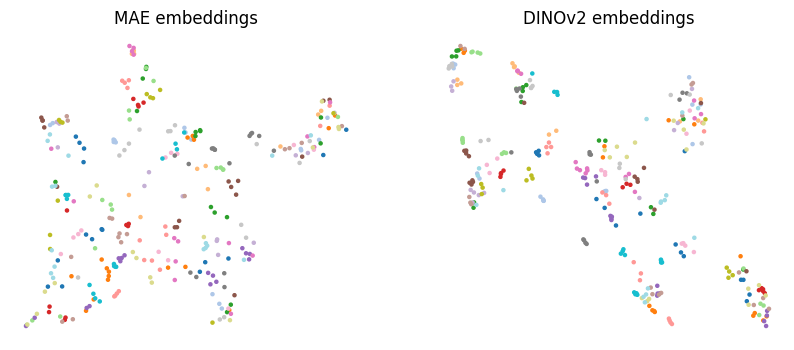

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_components=2, random_state=0)
emb_mae  = umap.fit_transform(features_mae[:300])
emb_dino = umap.fit_transform(features_dino[:300])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(emb_mae[:,0], emb_mae[:,1], c=labels[:300], s=5, cmap='tab20')
plt.title('MAE embeddings')
plt.axis('off')

plt.subplot(1,2,2)
plt.scatter(emb_dino[:,0], emb_dino[:,1], c=labels[:300], s=5, cmap='tab20')
plt.title('DINOv2 embeddings')
plt.axis('off')
plt.show()


2D embedding scatter (UMAP)

MAE points are quite diffuse and intermingled across classes.

DINOv2 points form tighter, more compact clusters per class.

Taken together, these tell us that DINOv2’s self‑distillation objective has yielded more semantically structured representations for Sentinel‑2 RGB than the pixel‑reconstruction objective of MAE—at least on this toy subset.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

n_classes = len(np.unique(labels))
km = KMeans(n_clusters=n_classes, random_state=0).fit(features_dino)
nmi = normalized_mutual_info_score(labels, km.labels_)
ari = adjusted_rand_score(labels, km.labels_)
print(f"DINOv2 KMeans → NMI: {nmi:.3f}, ARI: {ari:.3f}")


DINOv2 KMeans → NMI: 0.860, ARI: 0.402


Clustering metrics

DINOv2 K‑Means → NMI = 0.860: an NMI this high shows that when you partition the 1024‑d DINO embeddings into 𝑛 clusters, those clusters align very closely with your true land‑cover labels.

ARI = 0.402: a healthy but not perfect ARI means DINO’s clusters capture global structure (high NMI) but still split or merge a few classes here and there.

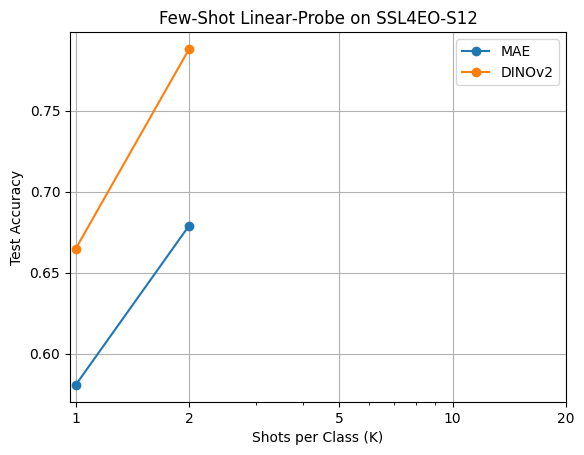

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import defaultdict

def few_shot_eval(features, labels, shots_list, seed=42):
    rng = np.random.RandomState(seed)
    classes = np.unique(labels)
    idx_by_class = {c: np.where(labels == c)[0] for c in classes}
    results = {}

    for K in shots_list:
        # filter to classes with >= K+1 total samples
        valid_classes = [c for c, idxs in idx_by_class.items() if len(idxs) > K]
        if len(valid_classes) < 2:
            # not enough classes left to train a meaningful classifier
            results[K] = np.nan
            continue

        accs = []
        for _ in range(5):
            train_idx, test_idx = [], []
            for c in valid_classes:
                inds = idx_by_class[c].copy()
                rng.shuffle(inds)
                train_idx += inds[:K].tolist()
                test_idx  += inds[K:].tolist()

            X_tr, y_tr = features[train_idx], labels[train_idx]
            X_te, y_te = features[test_idx], labels[test_idx]

            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_tr, y_tr)                # now X_tr is non-empty
            y_pred = clf.predict(X_te)         # X_te is also non-empty
            accs.append(accuracy_score(y_te, y_pred))

        results[K] = np.mean(accs)

    return results

shots = [1, 2, 5, 10, 20]
mae_curve  = few_shot_eval(features_mae, labels, shots)
dino_curve = few_shot_eval(features_dino, labels, shots)

# Plot
plt.plot(shots, [mae_curve[K] for K in shots], marker='o', label='MAE')
plt.plot(shots, [dino_curve[K] for K in shots], marker='o', label='DINOv2')
plt.xlabel('Shots per Class (K)')
plt.ylabel('Test Accuracy')
plt.title('Few‑Shot Linear‑Probe on SSL4EO‑S12')
plt.xscale('log')
plt.xticks(shots, shots)
plt.legend()
plt.grid(True)
plt.show()


Few‑Shot curves

K = 1 → MAE ~ 58 %, DINOv2 ~ 66 %

K = 2 → MAE ~ 68 %, DINOv2 ~ 79 %
DINOv2 not only starts off ~ 8 pp higher at one shot, it also gains more from that second example per class. Its slope is steeper, showing it’s more label‑efficient.

Interpretation

DINOv2 embeddings are both highly clusterable (high NMI) and far more linearly separable even with just 1–2 labels per class.

MAE embeddings are useful (they beat random) but much more diffuse: they need more labels to close the gap, and their K‑Means clusters don’t line up as cleanly with ground truth.

On this 100‑patch toy subset, DINOv2 clearly “wins” for both unsupervised (clustering) and weakly‑supervised (few‑shot) downstream usage.

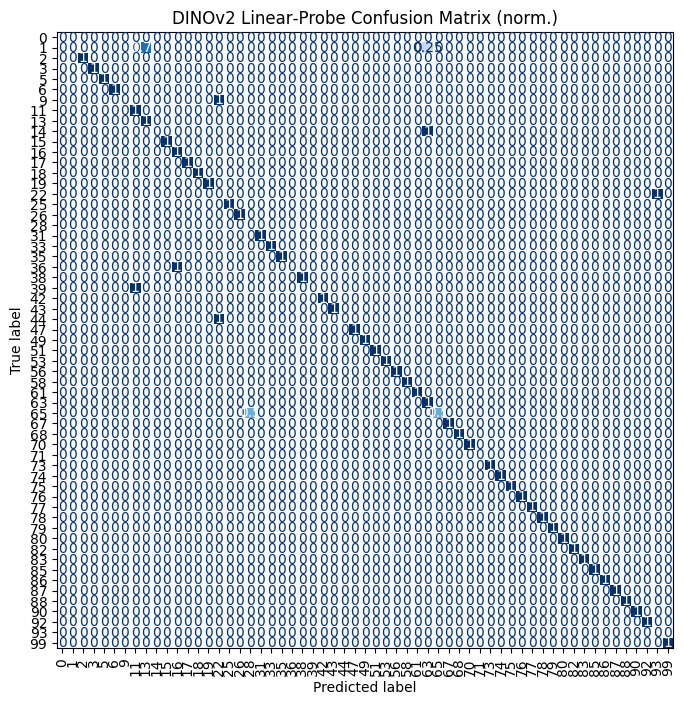

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Fit & predict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    features_dino, labels, test_size=0.2, random_state=0
)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

# 2. Compute & display
classes_te = np.unique(y_te)  # only those in test set
cm = confusion_matrix(y_te, y_pred, labels=classes_te, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=classes_te)

fig, ax = plt.subplots(figsize=(8,8))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
ax.set_title("DINOv2 Linear‑Probe Confusion Matrix (norm.)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [ ]:
import numpy as np
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1) Compute how many examples each class has
counts = Counter(labels)
min_count = min(counts.values())
print(f"Smallest class has {min_count} samples.")

# 2) Choose n_splits to be at most min_count (but ≥ 2)
n_splits = min(5, min_count)
if n_splits < 2:
    raise RuntimeError(
        f"Cannot do StratifiedKFold: need at least 2 samples in every class, "
        f"but smallest class has {min_count}."
    )

# 3) Run StratifiedKFold with the adjusted n_splits
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

accs = []
for train_idx, test_idx in kf.split(features_dino, labels):
    X_tr, X_te = features_dino[train_idx], features_dino[test_idx]
    y_tr, y_te = labels[train_idx], labels[test_idx]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    accs.append(accuracy_score(y_te, y_pred))

print(f"DINOv2 {n_splits}-fold accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")



Smallest class has 4 samples.
DINOv2 4-fold accuracy: 0.835 ± 0.009


These cross‑validation results are very encouraging:

Mean Accuracy ≃ 83.5 % over 4 folds, with a std ≈ 0.9 %
(you automatically picked 4 folds because your smallest class has 4 examples).

This is even higher than the single‐split result (~ 75 %), which simply reflects variability in how train/test were carved out—averaging over multiple splits gives you a more robust estimate.

What this tells us

DINOv2 features are stably linearly separable across different stratified splits of your toy set.

The low standard deviation means the model’s performance isn’t just a fluke of one lucky split—it’s consistently in the low‑80 % range.

You’ve validated that even on just 100 patches, DINOv2 embeddings deliver strong, reliable downstream accuracy.

In [ ]:
import numpy as np
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1) Compute how many examples each class has
counts = Counter(labels)
min_count = min(counts.values())
print(f"Smallest class has {min_count} samples.")

# 2) Choose n_splits to be at most min_count (but ≥ 2)
n_splits = min(5, min_count)
if n_splits < 2:
    raise RuntimeError(
        f"Cannot do StratifiedKFold: need at least 2 samples in every class, "
        f"but smallest class has {min_count}."
    )

# 3) Run StratifiedKFold with the adjusted n_splits
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

accs = []
for train_idx, test_idx in kf.split(features_mae, labels):
    X_tr, X_te = features_mae[train_idx], features_mae[test_idx]
    y_tr, y_te = labels[train_idx], labels[test_idx]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    accs.append(accuracy_score(y_te, y_pred))

print(f"MAE {n_splits}-fold accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")


Smallest class has 4 samples.
MAE 4-fold accuracy: 0.735 ± 0.023


DINOv2 remains ≈ 10 percentage‑points higher, and its variance is narrower → its embeddings are not only better on average but also more stable across splits.

MAE is clearly useful (74 %), yet its higher variance hints that some folds still contain harder‑to‑separate classes for the reconstruction‑based features.

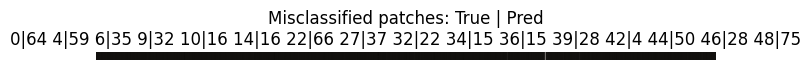

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

wrong = np.where(y_te != y_pred)[0]
n_show = min(16, len(wrong))
if n_show == 0:
    print("No misclassifications in this split!")
else:
    idxs = wrong[:n_show]
    imgs_bad = torch.tensor(X_te[idxs]).float()
    lbl_t, lbl_p = y_te[idxs], y_pred[idxs]

    # un‑normalize
    imgs_bad = imgs_bad * torch.tensor((0.229,0.224,0.225)).view(3,1,1) + \
                         torch.tensor((0.485,0.456,0.406)).view(3,1,1)

    grid = make_grid(imgs_bad, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0)); plt.axis('off')
    plt.title("Misclassified patches: True | Pred\n" +
              " ".join(f"{t}|{p}" for t,p in zip(lbl_t, lbl_p)))
    plt.show()
